In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-value-prediction-challenge/sample_submission.csv
/kaggle/input/santander-value-prediction-challenge/train.csv
/kaggle/input/santander-value-prediction-challenge/test.csv


In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999

In [41]:
train_df=pd.read_csv('/kaggle/input/santander-value-prediction-challenge/train.csv')
test_df= pd.read_csv('/kaggle/input/santander-value-prediction-challenge/test.csv')

Dataset has 4993 columns, most of them are seeming to be zero

In [42]:
train_df.head()

ID      target  48df886f9  0deb4b6a8  34b15f335  a8cb14b00  \
0  000d6aaf2  38000000.0        0.0          0        0.0          0   
1  000fbd867    600000.0        0.0          0        0.0          0   
2  0027d6b71  10000000.0        0.0          0        0.0          0   
3  0028cbf45   2000000.0        0.0          0        0.0          0   
4  002a68644  14400000.0        0.0          0        0.0          0   

   2f0771a37  30347e683  d08d1fbe3  6ee66e115  20aa07010  dc5a8f1d8  \
0          0          0          0          0        0.0        0.0   
1          0          0          0          0  2200000.0        0.0   
2          0          0          0          0        0.0        0.0   
3          0          0          0          0        0.0        0.0   
4          0          0          0          0  2000000.0        0.0   

   11d86fa6a  77c9823f2  8d6c2a0b2  4681de4fd  adf119b9a  cff75dd09  \
0        0.0          0          0          0          0        0.0   
1        0.0          0          0          0          0        0.0   
2        0.0          0          0          0          0        0.0   
3        0.0          0          0          0          0        0.0   
4        0.0          0          0          0          0        0.0   

   96f83a237  b8a716ebf  6c7a4567c  4fcfd2b4d  f3b9c0b95  71cebf11c  \
0          0        0.0          0          0        0.0          0   
1          0        0.0          0          0        0.0          0   
2          0        0.0          0          0        0.0          0   
3          0        0.0          0          0        0.0          0   
4          0        0.0          0          0        0.0          0   

   d966ac62c  68b647452  c88d108c9  ff7b471cd  d5308d8bc  0d866c3d7  \
0          0        0.0          0          0          0        0.0   
1          0        0.0          0          0          0        0.0   
2          0        0.0          0          0          0        0.0   
3          0        0.0          0          0          0        0.0   
4          0        0.0          0          0          0        0.0   

   bc3f77679  bd8f989f1  0eff5bf95  22ed6dba3  92b13ebba  c330f1a67  \
0          0        0.0          0        0.0        0.0          0   
1          0        0.0          0        0.0        0.0          0   
2          0        0.0          0        0.0        0.0          0   
3          0        0.0          0        0.0        0.0          0   
4          0        0.0          0        0.0        0.0          0   

   233c7c17c  2cb4d123e  eeac16933  87ffda550  822e49b95  316b978cd  \
0        0.0          0          0  1300000.0        0.0          0   
1        0.0          0          0        0.0        0.0          0   
2        0.0          0          0        0.0        0.0          0   
3        0.0          0          0        0.0        0.0          0   
4        0.0          0          0        0.0        0.0          0   

   d04e16aed  5d5c5ce6d  ec863cb52  11ad148bd  ea18d720e  408d86ce9  \
0        0.0          0          0        0.0        0.0        0.0   
1        0.0          0          0        0.0        0.0        0.0   
2        0.0          0          0        0.0        0.0        0.0   
3        0.0          0          0        0.0        0.0        0.0   
4        0.0          0          0        0.0        0.0        0.0   

   69d8b4020  b0868a049  80b14398e  ecdef52b2  c36bcacc5  151d318cd  \
0          0          0        0.0        0.0          0          0   
1          0          0        0.0        0.0          0          0   
2          0          0        0.0        0.0          0          0   
3          0          0        0.0        0.0          0          0   
4          0          0        0.0        0.0          0          0   

   ab0cddb90  2d6bd8275   dfdf4b580  c87722678  a8c320153  7df8788e8  \
0          0        0.0         0.0          0          0          0   
1          0     

Data has no null values

In [13]:
print(train_df.shape)
print(test_df.shape)

(4459, 4993)
(49342, 4992)


In [11]:
train_df.columns[train_df.isnull().sum()!=0].size

0

In [15]:
test_df.columns[test_df.isnull().sum()!=0].size

0

Analyze the target variable

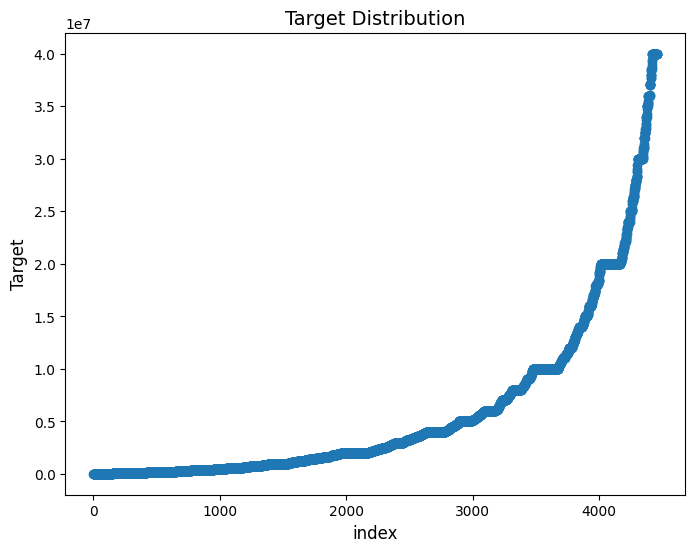

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]),np.sort(train_df['target'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()


Plot histogram now

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


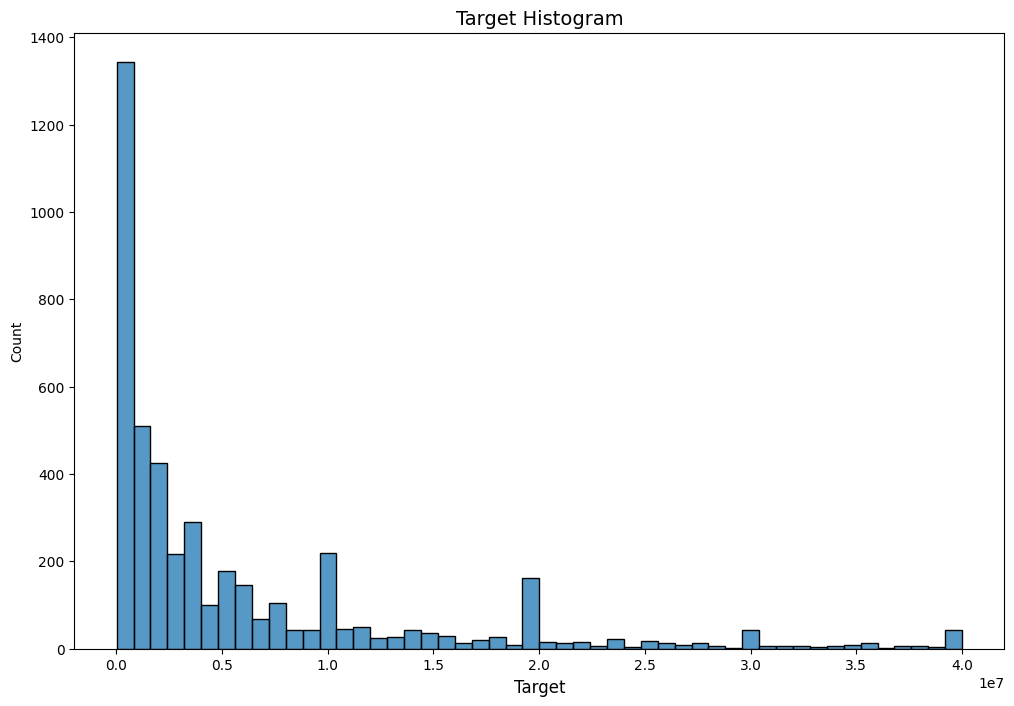

In [21]:
import seaborn as sns
plt.figure(figsize=(12,8))
sns.histplot(train_df["target"].values, bins=50, kde=False)
plt.xlabel('Target', fontsize=12)
plt.title("Target Histogram", fontsize=14)
plt.show()


Its skewed to the left
skewed distribution with majority of the data points having low value.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


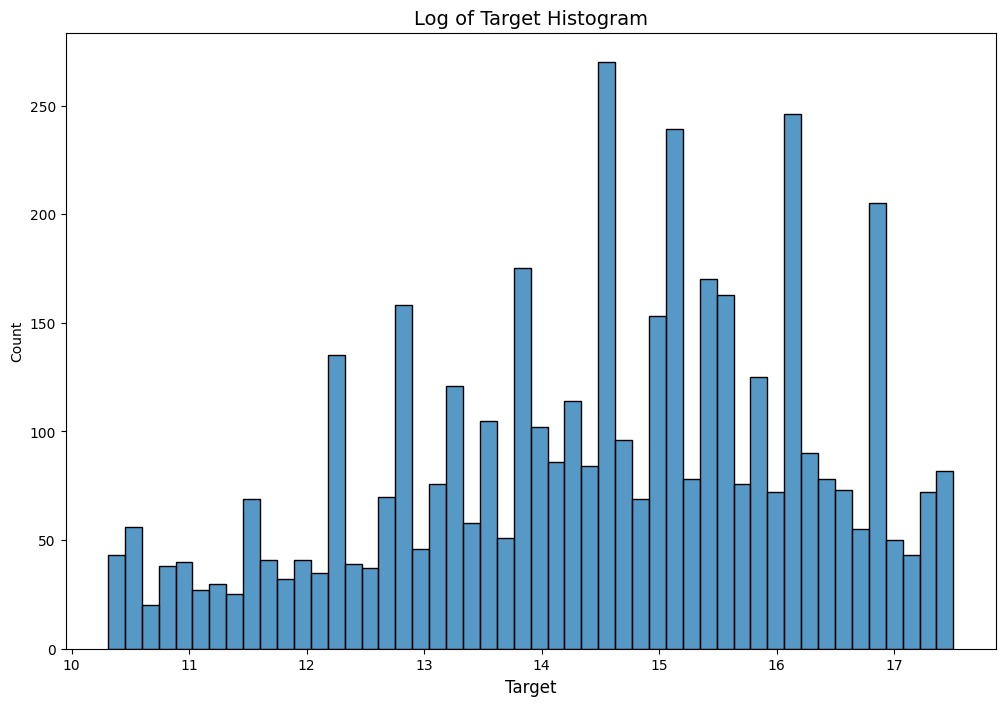

In [22]:
plt.figure(figsize=(12,8))
sns.histplot( np.log1p(train_df["target"].values), bins=50, kde=False)
plt.xlabel('Target', fontsize=12)
plt.title("Log of Target Histogram", fontsize=14)
plt.show()

Columns with constant values:

Generally when we get problems with many columns, there might be few columns with constant value in train set. So we can check that one as well.



In [43]:
unique_df = train_df.nunique().reset_index()
unique_df.columns = ["col_name", "unique_count"]
constant_df = unique_df[unique_df["unique_count"]==1]
constant_df.shape

(256, 2)

256 columns with constant values in the train set.Let's remove it

Correlation of features with target:

In [44]:
str(constant_df.col_name.tolist())

"['d5308d8bc', 'c330f1a67', 'eeac16933', '7df8788e8', '5b91580ee', '6f29fbbc7', '46dafc868', 'ae41a98b6', 'f416800e9', '6d07828ca', '7ac332a1d', '70ee7950a', '833b35a7c', '2f9969eab', '8b1372217', '68322788b', '2288ac1a6', 'dc7f76962', '467044c26', '39ebfbfd9', '9a5ff8c23', 'f6fac27c8', '664e2800e', 'ae28689a2', 'd87dcac58', '4065efbb6', 'f944d9d43', 'c2c4491d5', 'a4346e2e2', '1af366d4f', 'cfff5b7c8', 'da215e99e', '5acd26139', '9be9c6cef', '1210d0271', '21b0a54cb', 'da35e792b', '754c502dd', '0b346adbd', '0f196b049', 'b603ed95d', '2a50e001c', '1e81432e7', '10350ea43', '3c7c7e24c', '7585fce2a', '64d036163', 'f25d9935c', 'd98484125', '95c85e227', '9a5273600', '746cdb817', '6377a6293', '7d944fb0c', '87eb21c50', '5ea313a8c', '0987a65a1', '2fb7c2443', 'f5dde409b', '1ae50d4c3', '2b21cd7d8', '0db8a9272', '804d8b55b', '76f135fa6', '7d7182143', 'f88e61ae6', '378ed28e0', 'ca4ba131e', '1352ddae5', '2b601ad67', '6e42ff7c7', '22196a84c', '0e410eb3d', '992e6d1d3', '90a742107', '08b9ec4ae', 'd95203ded

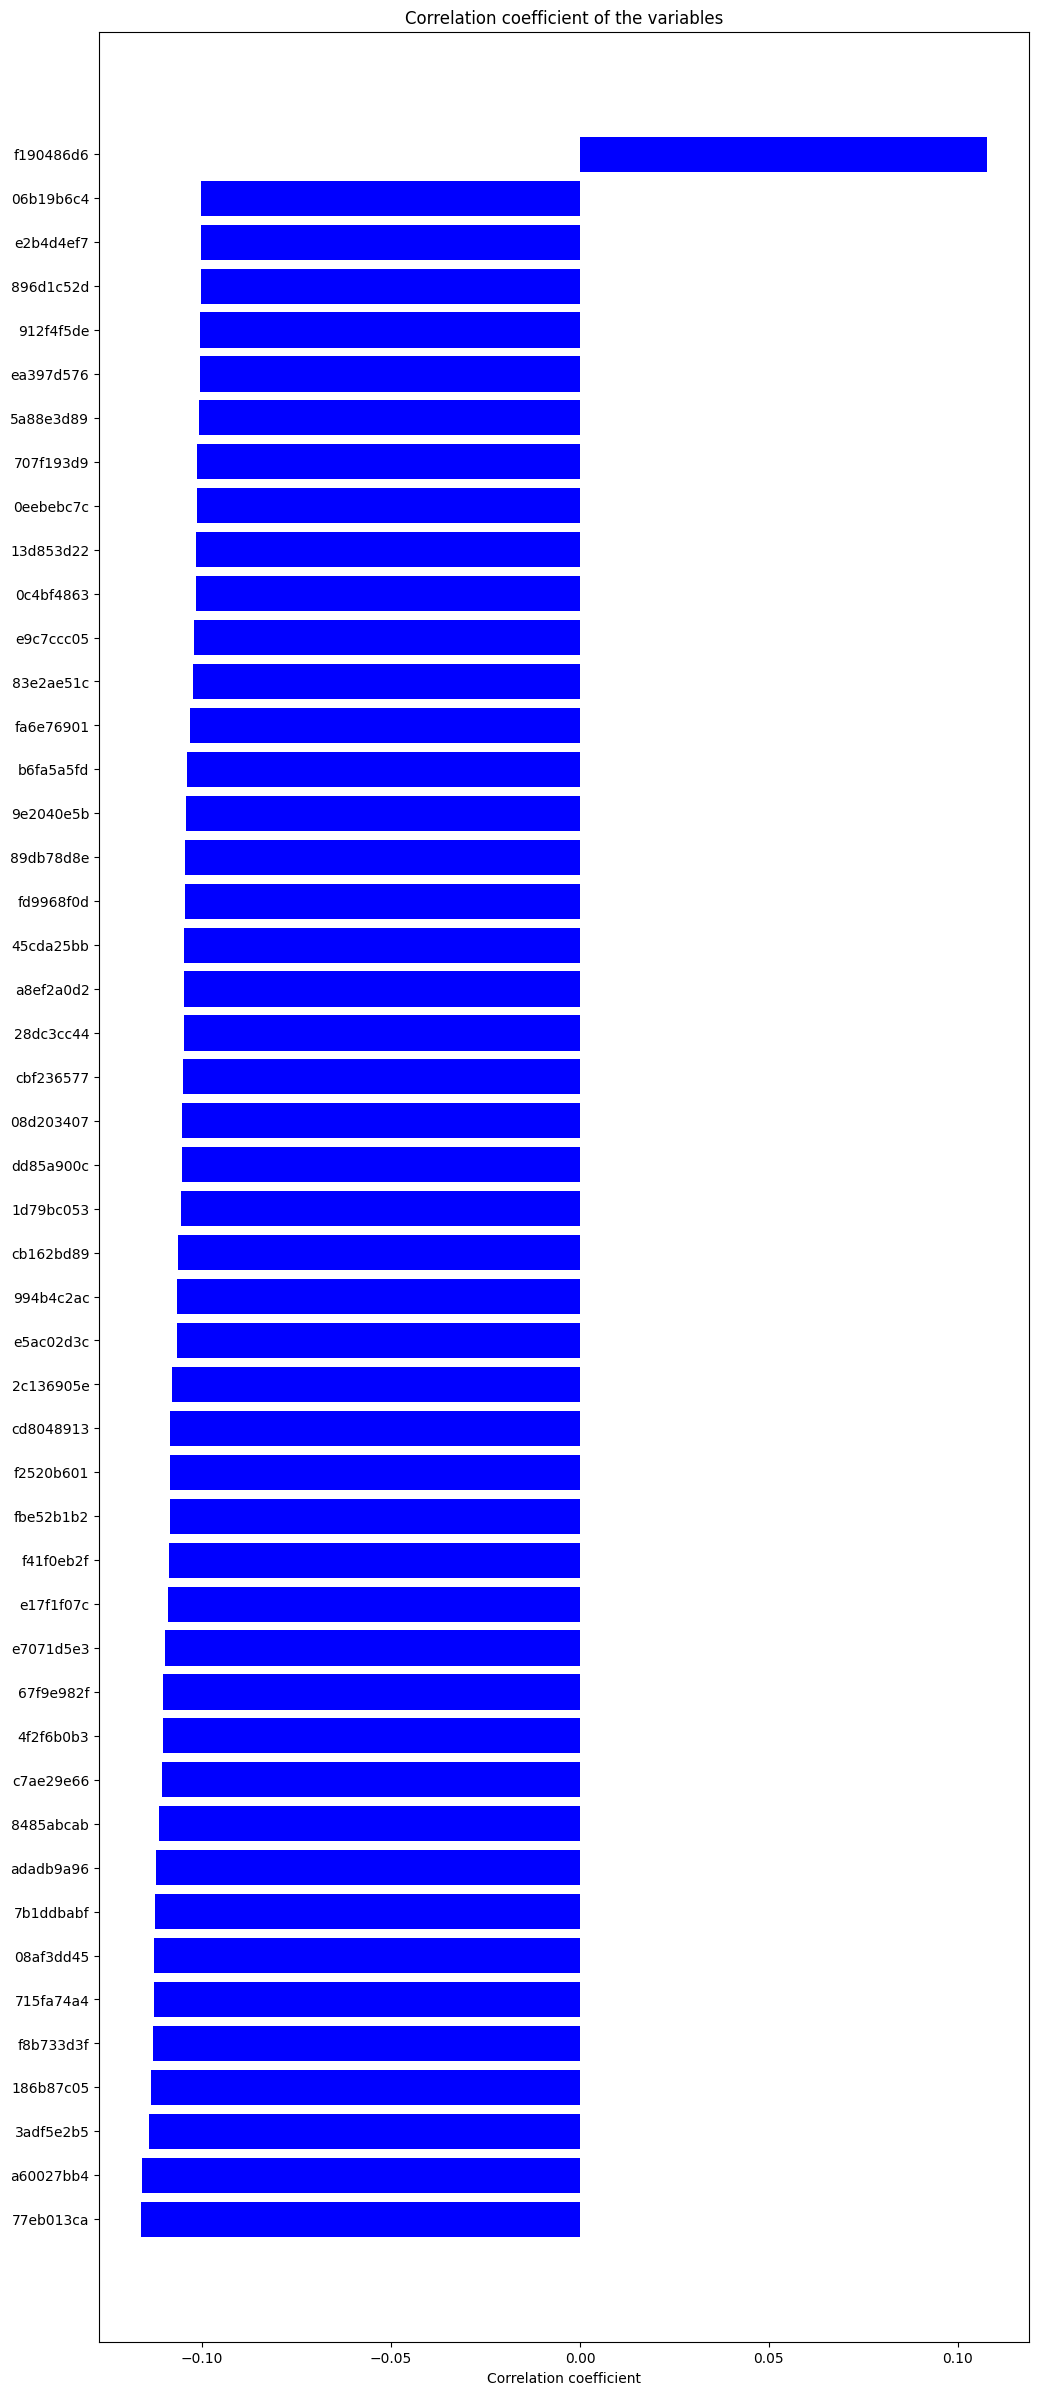

In [45]:
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings("ignore")

labels = []
values = []
for col in train_df.columns:
    if col not in ["ID", "target"]:
        labels.append(col)
        values.append(spearmanr(train_df[col].values, train_df["target"].values)[0])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
 
corr_df = corr_df[(corr_df['corr_values']>0.1) | (corr_df['corr_values']<-0.1)]
ind = np.arange(corr_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,30))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='b')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

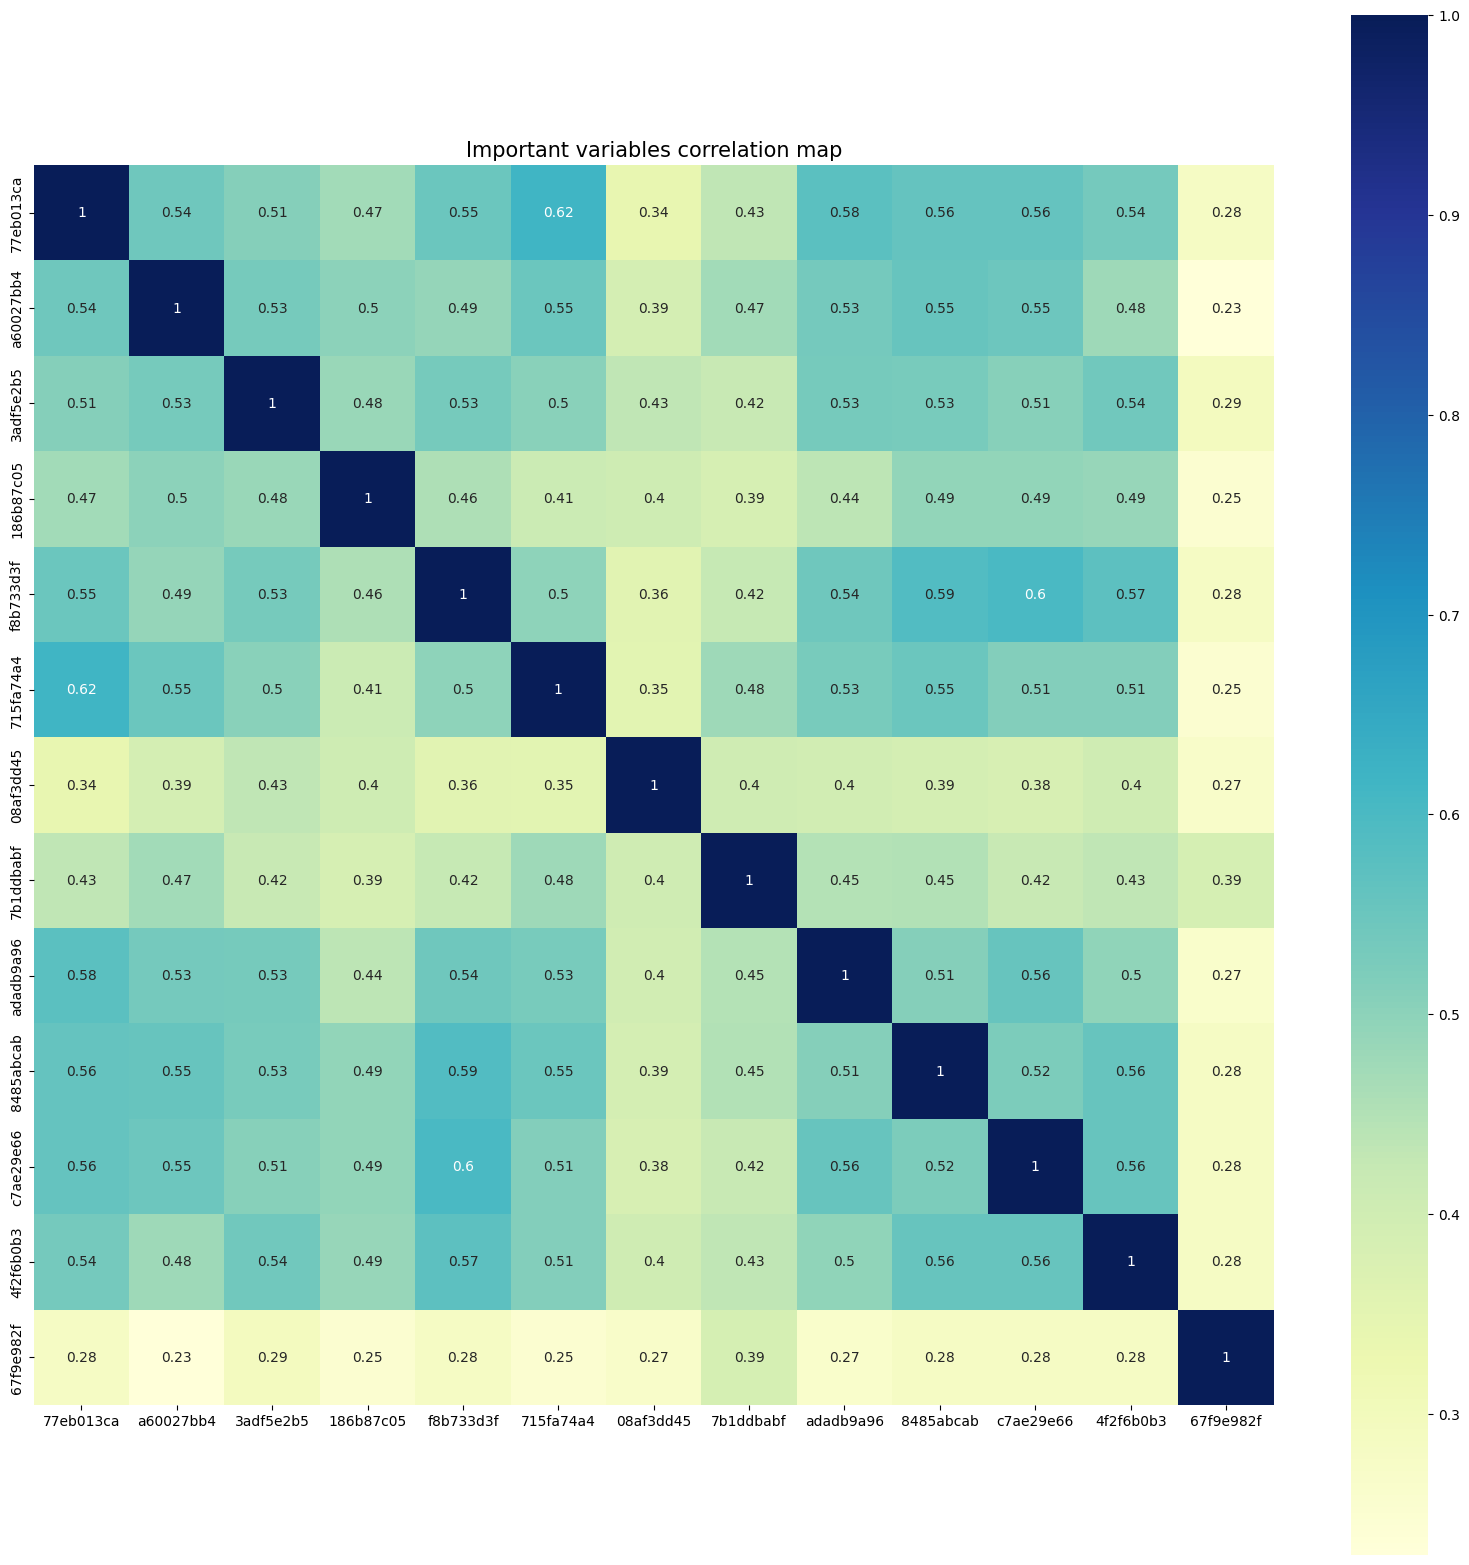

In [46]:
cols_to_use = corr_df[(corr_df['corr_values']>0.11) | (corr_df['corr_values']<-0.11)].col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()


Feature Importance - Extra trees model

In [47]:
### Get the X and y variables for building model ###
train_X = train_df.drop(constant_df.col_name.tolist() + ["ID", "target"], axis=1)
test_X = test_df.drop(constant_df.col_name.tolist() + ["ID"], axis=1)
train_y = np.log1p(train_df["target"].values)

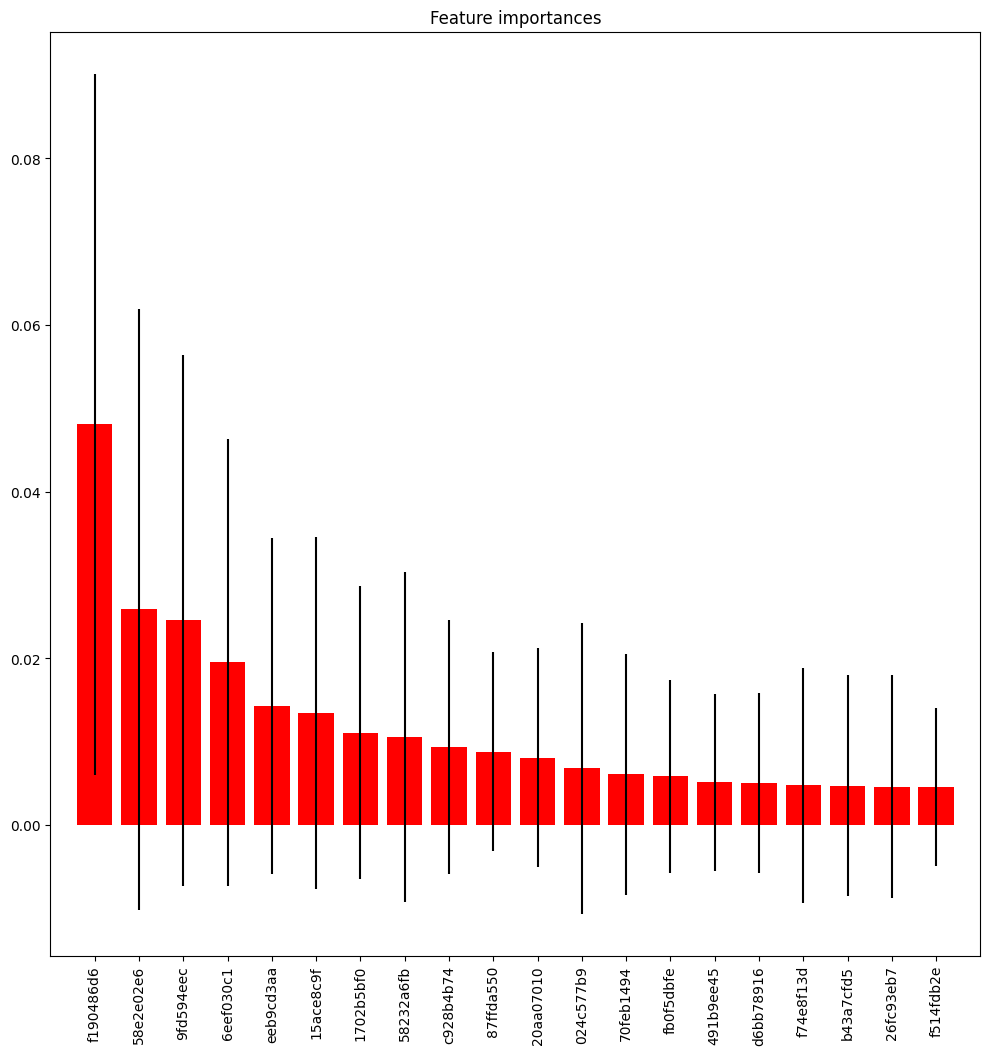

In [48]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

## plot the importances ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [60]:
import lightgbm as lgb
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval])
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [55]:
pip install --upgrade lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 25.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.2.0
    Uninstalling lightgbm-4.2.0:
      Successfully uninstalled lightgbm-4.2.0
Note: you may need to restart the kernel to use updated packages.


In [61]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

In [64]:
# Making a submission file #
sub_df = pd.DataFrame({"ID":test_df["ID"].values})
sub_df["target"] = pred_test_full
sub_df.to_csv("3_lgb.csv", index=False)


1.47 score 